In [1]:
!git clone 'https://github.com/shilpiprd/Biparietal_Occipitofrontal-Diameter-Detection.git'
%cd /content/Biparietal_Occipitofrontal-Diameter-Detection

Cloning into 'Biparietal_Occipitofrontal-Diameter-Detection'...
remote: Enumerating objects: 1255, done.
remote: Counting objects: 100% (628/628), done.
remote: Compressing objects: 100% (626/626), done.
remote: Total 1255 (delta 2), reused 627 (delta 2), pack-reused 627
Receiving objects: 100% (1255/1255), 81.36 MiB | 29.96 MiB/s, done.
Resolving deltas: 100% (2/2), done.
/content/Biparietal_Occipitofrontal-Diameter-Detection


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
from PIL import Image
from PIL import Image, ImageOps
import scipy.ndimage
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [3]:
data = pd.read_csv('/content/Biparietal_Occipitofrontal-Diameter-Detection/role_challenge_dataset_ground_truth.csv')
images = os.listdir('/content/Biparietal_Occipitofrontal-Diameter-Detection/images/')
print(data.shape, len(images))
data.head(4)

(622, 9) 622


,image_name,ofd_1_x,ofd_1_y,ofd_2_x,ofd_2_y,bpd_1_x,bpd_1_y,bpd_2_x,bpd_2_y
0,000_HC.png,361,12,339,530,481,16,664,318
1,001_HC.png,441,331,368,308,297,247,534,142
2,002_HC.png,318,374,154,406,481,158,558,215
3,003_HC.png,424,105,407,462,305,349,547,363


In [4]:
#check all input image sizes
base_path = '/content/Biparietal_Occipitofrontal-Diameter-Detection/images'
image_paths = os.listdir(base_path)
s = set()
for image_path in image_paths:
      actual_path = os.path.join(base_path, image_path)
      with Image.open(actual_path).convert('L') as img: #l is for grayscale mode
            original_shape = img.size
            # print(original_shape)
            s.add(original_shape)
print(s)

{(794, 544), (790, 539), (797, 541), (800, 540), (783, 543), (780, 544), (794, 543), (799, 563), (738, 541), (788, 545), (786, 542), (800, 542), (780, 539), (782, 542), (783, 541)}


original_image.size:  (800, 540)


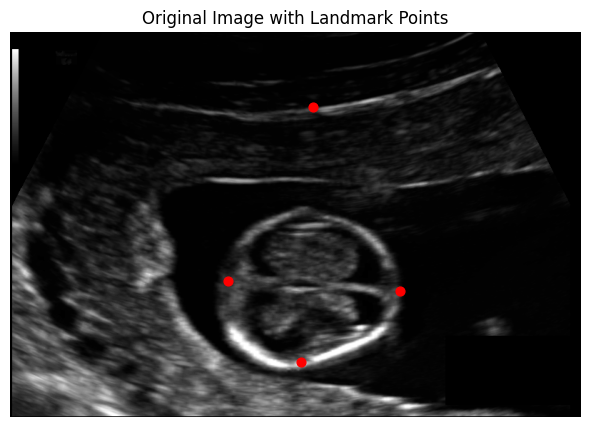

In [5]:
#take a look at the data given: plot original coordinates on original image
def visualize_individual_points(image, coordinates):
    plt.figure(figsize=(10, 5))
    plt.imshow(image, cmap='gray', aspect='equal')
    for coord in coordinates:
        x, y = coord
        x, y = int(x), int(y)  # Ensure coordinates are integers
        plt.scatter([x], [y], c='r', s=40)
    plt.title("Original Image with Landmark Points")
    plt.axis('off')
    plt.show()

original_image = Image.open('/content/Biparietal_Occipitofrontal-Diameter-Detection/images/003_HC.png').convert('L')
print('original_image.size: ', original_image.size)
image = np.array(original_image)/ 255.0 #normalizing
my_coord = [(424, 105), (407, 462), (305, 349), (547, 363)] #wrote myself
visualize_individual_points(image, my_coord)

<b>It seems the given annotated images are not properly annotated which could lead to bad training and test accuracy.</b>

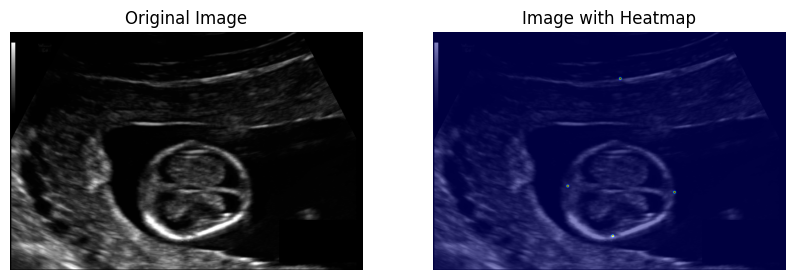

In [6]:
#try creating heatmaps and plotting it, for a specific image
def create_heatmap(coords, image_shape, sigma=2):
    heatmap = np.zeros(image_shape, dtype=np.float32)  # Initialize heatmap
    for x, y in coords:
        if y < image_shape[0] and x < image_shape[1]:
            heatmap[y, x] = 1  # Mark the landmark position with a 1
    heatmap = scipy.ndimage.gaussian_filter(heatmap, sigma=sigma)
    return heatmap

def visualize_image_and_heatmap(image, heatmap):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray', aspect = 'equal')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(image, cmap='gray')
    plt.imshow(heatmap, alpha=0.5, cmap='jet', aspect='equal')  # Overlay heatmap
    plt.title("Image with Heatmap")
    plt.axis('off')
    plt.show()

# type(iamge): <class 'numpy.ndarray'>, type(heatmap): <class 'numpy.ndarray'>
# type(iamge): <class 'numpy.ndarray'>, type(heatmap): <class 'numpy.ndarray'>

original_image = Image.open('/content/Biparietal_Occipitofrontal-Diameter-Detection/images/003_HC.png').convert('L')
image = np.array(original_image)/ 255.0
my_coord = [(424, 105), (407, 462), (305, 349), (547, 363)]
heatmap = create_heatmap(my_coord,(original_image.size[1], original_image.size[0]))
visualize_image_and_heatmap(image, heatmap)

<b>It seems some images are indeed annotated wrong, as it's shown even in the heatmaps. </b>

In [7]:
#check if there are any nulll values in any of the features
cols = [col for col in data.columns if data[col].isnull().any()]
print(cols) #no null values anywhere

[]


In [8]:
#converting coordinates into tuples to feed into heatmap function
all_coordinates = []
for index, row in data.iterrows():
    ofd_1 = (row['ofd_1_x'], row['ofd_1_y'])
    ofd_2 = (row['ofd_2_x'], row['ofd_2_y'])
    bpd_1 = (row['bpd_1_x'], row['bpd_1_y'])
    bpd_2 = (row['bpd_2_x'], row['bpd_2_y'])
    coordinates = [ofd_1, ofd_2, bpd_1, bpd_2]
    all_coordinates.append(coordinates)

<ipython-input-9-2d6b8b4578c0>:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = img.resize((new_width, new_height), Image.ANTIALIAS)


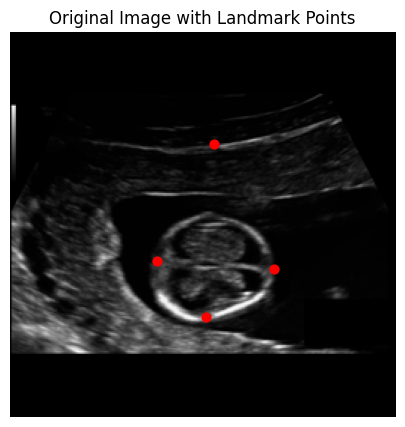

In [9]:
#visualize resized image with coordinates on them
def resize_image_with_padding(img, target_size):
    aspect_ratio = img.width / img.height
    if target_size[0] / target_size[1] > aspect_ratio:
        new_height = target_size[1]
        new_width = round(new_height * aspect_ratio)
    else:
        new_width = target_size[0]
        new_height = round(new_width / aspect_ratio)
    resized_image = img.resize((new_width, new_height), Image.ANTIALIAS)
    padded_image = Image.new('L', target_size, 0)
    padding_top = (target_size[1] - new_height) // 2
    padding_left = (target_size[0] - new_width) // 2
    padded_image.paste(resized_image, (padding_left, padding_top))

    return padded_image, (padding_left, padding_top, new_width, new_height)

def scale_coordinates(coords, original_size, padding_info, target_size):
    padding_left, padding_top, new_width, new_height = padding_info
    x_scale = new_width / original_size[0]
    y_scale = new_height / original_size[1]
    scaled_coords = [(int(x * x_scale + padding_left), int(y * y_scale + padding_top)) for x, y in coords]

    return scaled_coords

original_image = Image.open('/content/Biparietal_Occipitofrontal-Diameter-Detection/images/003_HC.png').convert('L')
target_size = (256, 256)
resized_image, padding_info= resize_image_with_padding(original_image, target_size)
original_coordinates = [(424, 105), (407, 462), (305, 349), (547, 363)]
scaled_coordinates = scale_coordinates(original_coordinates, original_image.size, padding_info, target_size)
visualize_individual_points(resized_image, scaled_coordinates)

**resizing of image and scaling of coordinates is working fine.**

<ipython-input-9-2d6b8b4578c0>:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = img.resize((new_width, new_height), Image.ANTIALIAS)


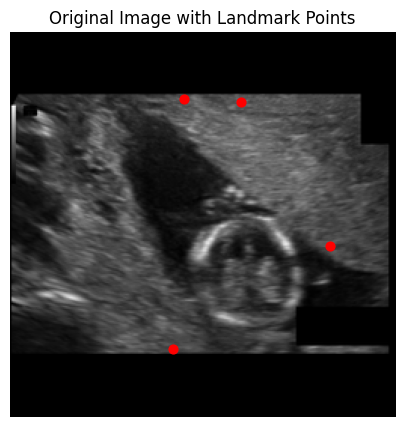

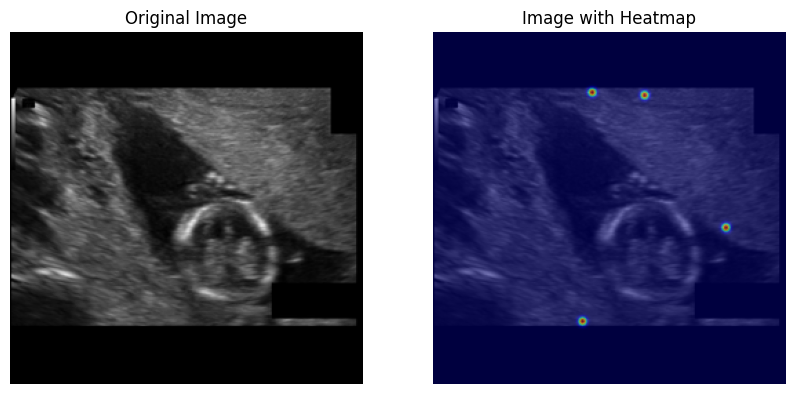

In [10]:
#check if resizing works with heatmap images properly as well.
base_path = '/content/Biparietal_Occipitofrontal-Diameter-Detection/images/'
image_paths = os.listdir(base_path)
count = 0
for image_path, coordinates in zip(image_paths, all_coordinates): #all_cooordinates isn't processed yet
        if count == 1:
                break
        full_path = os.path.join(base_path, image_path)
        with Image.open(full_path).convert('L') as img:
                target_size = (256, 256)
                resized_image, padding_info= resize_image_with_padding(img, target_size)
                scaled_coordinates = scale_coordinates(coordinates, img.size, padding_info, target_size)
                scaled_heatmap = create_heatmap(scaled_coordinates,(target_size[1], target_size[0]))
                visualize_individual_points(np.array(resized_image), scaled_coordinates)
                visualize_image_and_heatmap(resized_image, scaled_heatmap)
                count += 1


<b>Now since all the resizing and heatmap generation function works properly, create a feature dictionary.</b>

In [11]:
base_path = '/content/Biparietal_Occipitofrontal-Diameter-Detection/images/'
image_paths = os.listdir(base_path)
feature_dictionary = {'file_image_paths':[], 'image': [], 'heatmap': []}

for image_path, coordinates in zip(image_paths, all_coordinates): #all_cooordinates isn't processed yet
        full_path = os.path.join(base_path, image_path)
        with Image.open(full_path).convert('L') as img:
                target_size = (256, 256)
                resized_image, padding_info= resize_image_with_padding(img, target_size)
                scaled_coordinates = scale_coordinates(coordinates, img.size, padding_info, target_size)
                scaled_heatmap = create_heatmap(scaled_coordinates,(target_size[1], target_size[0]))
                #  Store the resized image and heatmap in the feature dictionary
                feature_dictionary['file_image_paths'].append(full_path)
                feature_dictionary['image'].append(np.array(resized_image) / 255.0)  # Normalize the pixel values
                feature_dictionary['heatmap'].append(scaled_heatmap)

<ipython-input-9-2d6b8b4578c0>:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = img.resize((new_width, new_height), Image.ANTIALIAS)


<b>Now since we've feature dictionary, split into train, test</b>

In [12]:
#get a basic unet architecture, but split the dataset first
x = np.array(feature_dictionary['image'])
y = np.array(feature_dictionary['heatmap'])
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [13]:
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

497 125
497 125


In [14]:
X_train.shape #so we've 497 images of shape 256x256

(497, 256, 256)

In [15]:
SEED = 1
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Adding channel dimension
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Adding channel dimension
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

mean, std = 0.5, 0.5  #taking standard values
X_train_normalized = (X_train_tensor - mean) / std
X_test_normalized = (X_test_tensor - mean) / std

# Create TensorDataset
train_dataset = TensorDataset(X_train_normalized, y_train_tensor)
test_dataset = TensorDataset(X_test_normalized, y_test_tensor)

# CUDA check
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)

# Dataloader arguments
dataloader_args = dict(batch_size=32, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# Create DataLoaders
train_loader = DataLoader(train_dataset,shuffle = True, **dataloader_args)
test_loader = DataLoader(test_dataset, shuffle = False, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [16]:
#basic cut-down unet architecture
from torchsummary import summary
import torch
import torch.nn as nn
import torch.nn.functional as F
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        # Encoder
        self.e11 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.e12 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e21 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.e22 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e31 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.e32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e41 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.e42 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        # Decoder
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(32, 32, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = F.relu(self.e11(x))
        xe12 = F.relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = F.relu(self.e21(xp1))
        xe22 = F.relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = F.relu(self.e31(xp2))
        xe32 = F.relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = F.relu(self.e41(xp3))
        xe42 = F.relu(self.e42(xe41))

        # Decoder
        xu3 = self.upconv3(xe42)
        xu33 = torch.cat([xu3, xe32], dim=1)
        xd31 = F.relu(self.d31(xu33))
        xd32 = F.relu(self.d32(xd31))

        xu2 = self.upconv2(xd32)
        xu22 = torch.cat([xu2, xe22], dim=1)
        xd21 = F.relu(self.d21(xu22))
        xd22 = F.relu(self.d22(xd21))

        xu1 = self.upconv1(xd22)
        xu11 = torch.cat([xu1, xe12], dim=1)
        xd11 = F.relu(self.d11(xu11))
        xd12 = F.relu(self.d12(xd11))

        # Output layer
        out = self.outconv(xd12)
        return out

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = UNet(1).to(device)

# Print model summary
summary(model, input_size=(1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             320
            Conv2d-2         [-1, 32, 256, 256]           9,248
         MaxPool2d-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          18,496
            Conv2d-5         [-1, 64, 128, 128]          36,928
         MaxPool2d-6           [-1, 64, 64, 64]               0
            Conv2d-7          [-1, 128, 64, 64]          73,856
            Conv2d-8          [-1, 128, 64, 64]         147,584
         MaxPool2d-9          [-1, 128, 32, 32]               0
           Conv2d-10          [-1, 256, 32, 32]         295,168
           Conv2d-11          [-1, 256, 32, 32]         590,080
  ConvTranspose2d-12          [-1, 128, 64, 64]         131,200
           Conv2d-13          [-1, 128, 64, 64]         295,040
           Conv2d-14          [-1, 128,

In [17]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []
lrs = []
def get_lr(optimizer): #for implementing OneCycleLRPolicy
  for param_group in optimizer.param_groups:
    return param_group['lr']

def calculate_pixel_accuracy(output, target, threshold=0.5):
    predicted = output > threshold
    true_positives = (predicted == target).sum().item()
    total_pixels = torch.numel(predicted)
    accuracy = true_positives / total_pixels
    return accuracy

def train(model, device, train_loader, optimizer, scheduler, criterion):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        # Get samples
        data, target = data.to(device), target.to(device)

        # Initialize optimizer
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(data)

        # Calculate loss
        loss = criterion(y_pred, target)
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update progress bar description
        pbar.set_description(desc=f'Loss={loss.item()} Batch_id={batch_idx}')
    return train_losses

def test(model, device, test_loader, criterion):
    test_loss=0
    model.eval()
    total_accuracy = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() * data.size(0)
            total_accuracy += calculate_pixel_accuracy(output, target)

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    average_accuracy = total_accuracy / len(test_loader)
    print('\nTest set: Average loss: {:.4f}, Average Pixel Accuracy: {:.2f}%\n'.format(test_loss, average_accuracy * 100))
    return test_loss, test_losses

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.MSELoss()
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 20) #if loss doens't decrease with 20 steps

EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_losses = train(model, device, train_loader, optimizer, scheduler, criterion) #adding criterion as argument
    test_loss, test_losses = test(model, device, test_loader, criterion)
    scheduler.step(test_loss)

EPOCH: 0


Loss=0.0019444945501163602 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.99it/s]



Test set: Average loss: 0.0025, Average Pixel Accuracy: 98.24%

EPOCH: 1


Loss=8.803755918052047e-06 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.11it/s]



Test set: Average loss: 0.0001, Average Pixel Accuracy: 98.24%

EPOCH: 2


Loss=5.276556112221442e-05 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 3


Loss=3.1424486223841086e-05 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.06it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 4


Loss=9.230770956492051e-06 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.06it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 5


Loss=3.623006250563776e-06 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.02it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 6


Loss=2.9878117402404314e-06 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.01it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 7


Loss=3.1483787097386084e-06 Batch_id=15: 100%|██████████| 16/16 [00:07<00:00,  2.01it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 8


Loss=3.0523926852765726e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.99it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 9


Loss=3.0509681891999207e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.95it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 10


Loss=2.9944910693302518e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 11


Loss=2.8568845209520077e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 12


Loss=2.9680941224796697e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 13


Loss=2.932636334662675e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.92it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 14


Loss=2.9769896627840353e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.95it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 15


Loss=2.8936212856933707e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.96it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 16


Loss=2.7922640128963394e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.96it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 17


Loss=2.815837206071592e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.98it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 18


Loss=2.832309291989077e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.99it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 19


Loss=2.7119863261759747e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.96it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 20


Loss=2.7249047889199574e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.95it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 21


Loss=2.6530410650593694e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 22


Loss=2.704416829146794e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.96it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 23


Loss=2.6629732019500807e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.95it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 24


Loss=2.563867838034639e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 25


Loss=2.7023579605156556e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.95it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 26


Loss=2.726105549299973e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 27


Loss=2.436759132251609e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.96it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 28


Loss=2.4836574539222056e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.96it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 29


Loss=2.554881120886421e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.96it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 30


Loss=2.474066377544659e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.92it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 31


Loss=2.534469786041882e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.95it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 32


Loss=2.5378492409799946e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.96it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 33


Loss=2.4695018510101363e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.96it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 34


Loss=2.4797791411401704e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.92it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 35


Loss=2.459849838487571e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.95it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 36


Loss=2.4429284621874103e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.95it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 37


Loss=2.4594530714239227e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.96it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 38


Loss=2.459245479258243e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.91it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 39


Loss=2.4298001335409936e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.95it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 40


Loss=2.406094154139282e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 41


Loss=2.4168018626369303e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 42


Loss=2.382023012614809e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.92it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 43


Loss=2.314499170097406e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 44


Loss=2.372145445406204e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.95it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 45


Loss=2.335483941351413e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.93it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 46


Loss=2.3859886368882144e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 47


Loss=2.3563814011140494e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.95it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 48


Loss=2.309368710484705e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%

EPOCH: 49


Loss=2.2444628484663554e-06 Batch_id=15: 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]



Test set: Average loss: 0.0000, Average Pixel Accuracy: 98.24%



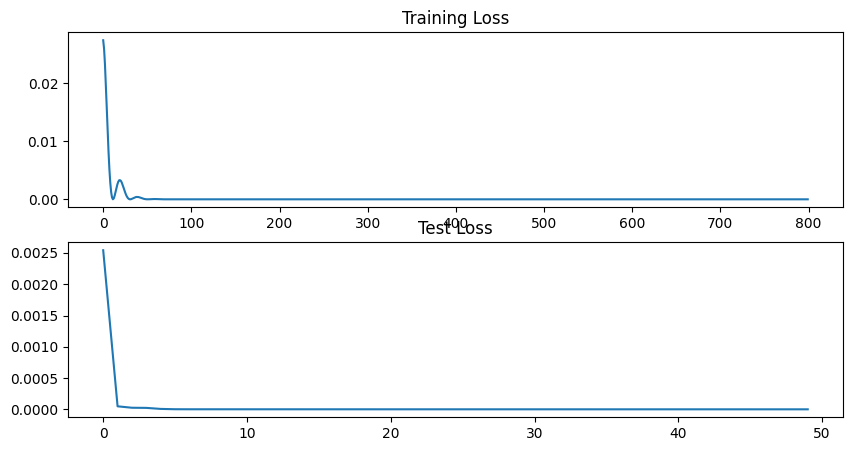

In [18]:
#visualizing train and test loss:
train_loss_values = [loss.item() if not isinstance(loss, float) else loss for loss in train_losses]
test_loss_values = [loss if isinstance(loss, float) else loss.item() for loss in test_losses]
fig, axs = plt.subplots(2, 1, figsize=(10, 5))  # 2 rows, 1 column for subplots
axs[0].plot(train_loss_values)
axs[0].set_title("Training Loss")
axs[1].plot(test_loss_values)
axs[1].set_title("Test Loss")
plt.show()

In [19]:
#get the name of test images
base_path = '/content/Biparietal_Occipitofrontal-Diameter-Detection/images/'
image_paths = [os.path.join(base_path, img) for img in sorted(os.listdir(base_path))]
all_images = np.array(feature_dictionary['image'])
all_coordinates = np.array(feature_dictionary['heatmap'])

# Split the dataset into training and test sets along with their corresponding image paths
X_train, X_test, y_train, y_test, image_paths_train, image_paths_test = train_test_split(
    all_images, all_coordinates, image_paths, test_size=0.2, random_state=42
)
print(len(image_paths_test)) # 125, same as no. of images in test_loader

125


torch.Size([32, 1, 256, 256])
type(iamge): <class 'torch.Tensor'>, type(heatmap): <class 'torch.Tensor'>


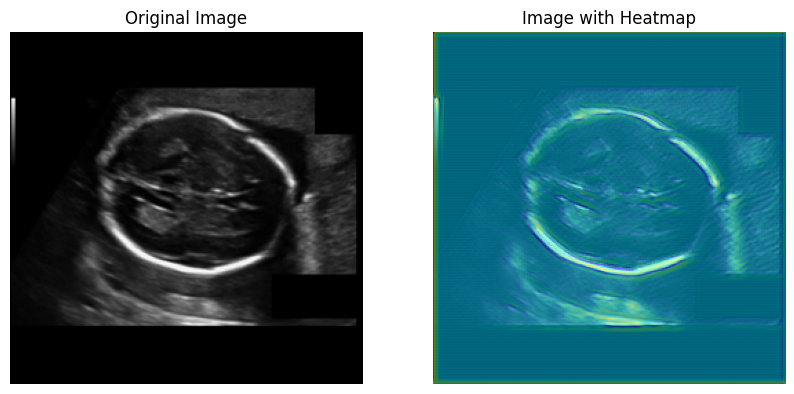

In [20]:
#visualize the output you've predicted
def visualize_image_and_heatmap(image, heatmap):
    print('type(iamge): {}, type(heatmap): {}'.format(type(image), type(heatmap)))
    if image.shape[1:] != heatmap.shape[1:]:
        raise ValueError(f"Image and heatmap shapes do not match: {image.shape} vs {heatmap.shape}")
    image = image.cpu().detach() if image.requires_grad else image.cpu()
    heatmap = heatmap.cpu().detach() if heatmap.requires_grad else heatmap.cpu()
    image_np = image.numpy()
    heatmap_np = heatmap.numpy()
    image_np = image_np[0, 0, :, :] if image_np.ndim == 4 else image_np[0, :, :]  # Assuming (batch_size, channels, H, W)
    heatmap_np = heatmap_np[0, 0, :, :] if heatmap_np.ndim == 4 else heatmap_np[0, :, :]  # Same assumption

    # Visualization
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image_np, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(image_np, cmap='gray')
    plt.imshow(heatmap_np, alpha=0.5, cmap='jet')
    plt.title("Image with Heatmap")
    plt.axis('off')
    plt.show()

for index, (data, target) in enumerate(test_loader):
    if(index == 1):
      data, target = data.to(device), target.to(device)
      output_heatmap = model(data)
      print(output_heatmap.shape)
      visualize_image_and_heatmap(data, output_heatmap)

In [21]:
#try to extract coordinates
def extract_coordinates_from_heatmap(heatmap, num_points=4):
    flat_indices = torch.topk(heatmap.view(-1), num_points).indices
    coords = [(int(idx % heatmap.shape[-1]), int(idx // heatmap.shape[-1])) for idx in flat_indices]

    return coords

image_names = [path.split('/')[-1] for path in image_paths_test]
results = pd.DataFrame(columns=['image', 'predicted_coords'])

for idx, (data, target) in enumerate(test_loader):
    data, target = data.to(device), target.to(device)
    for i in range(data.size(0)):
        single_image = data[i].unsqueeze(0)
        single_target = target[i].unsqueeze(0)
        output_heatmap = model(single_image)
        heatmap_tensor = torch.tensor(output_heatmap)
        predicted_coords = extract_coordinates_from_heatmap(heatmap_tensor, num_points=4)
        results = results.append({'image': image_names[idx], 'predicted_coords': predicted_coords}, ignore_index=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-21-ce7cab0fce93>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  heatmap_tensor = torch.tensor(output_heatmap)
<ipython-input-21-ce7cab0fce93>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'image': image_names[idx], 'predicted_coords': p

In [30]:
results['predicted_coords']

0        [(0, 0), (0, 1), (0, 215), (1, 0)]
1      [(0, 0), (0, 1), (0, 215), (0, 214)]
2        [(0, 0), (0, 203), (0, 1), (1, 0)]
3      [(0, 0), (0, 1), (0, 212), (0, 211)]
4          [(0, 0), (0, 1), (1, 0), (0, 3)]
                       ...                 
120      [(0, 0), (0, 1), (0, 211), (1, 0)]
121    [(0, 0), (0, 1), (0, 214), (0, 215)]
122      [(0, 0), (0, 1), (0, 215), (1, 0)]
123        [(0, 0), (0, 1), (1, 0), (0, 3)]
124        [(0, 0), (0, 1), (1, 0), (0, 3)]
Name: predicted_coords, Length: 125, dtype: object

In [22]:
# Save the model state dictionary
model_save_path = 'model1_weights.pth'
torch.save(model.state_dict(), model_save_path)